In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
import json

In [19]:
# For each point of the road on the left side, find the closest point on the right side
def get_middle_point(coordinates: tuple, list_coordinates: list[tuple]):
    min_distance = 100000
    closest_point = None

    for temp_coordinates in list_coordinates:
        distance = ((coordinates[0] - temp_coordinates[0]) ** 2 + (coordinates[1] - temp_coordinates[1]) ** 2) ** 0.5
        if distance < min_distance:
            min_distance = distance
            closest_point = temp_coordinates

            # get midlle of coordinates and closest point
            x_middle = (coordinates[0] + closest_point[0]) / 2
            y_middle = (coordinates[1] + closest_point[1]) / 2
            middle_point = (x_middle, y_middle)


    return middle_point

In [20]:
## Get the corrdinates of the points in the middle of the road
## And save them in a csv file

# Read the coordinates of the left and right side of the road from csv files
left_side_road_coordinates = pd.read_csv('RL_map_training/road_left.csv')
right_side_road_coordinates = pd.read_csv('RL_map_training/road_right.csv')

# Convert the dataframes to lists
right_side_list_coordinates = list(zip(right_side_road_coordinates.x_values, right_side_road_coordinates.y_values))
left_side_list_coordinates = list(zip(left_side_road_coordinates.x_values, left_side_road_coordinates.y_values))

# Initialize the list of the coordinates of the points in the middle of the road
middle_side_list_coordinates = []

# For each point of the road on the left side, find the closest point on the right side
for points in left_side_list_coordinates:
    middle_point = get_middle_point(points, right_side_list_coordinates)
    middle_side_list_coordinates.append(middle_point)

# Save the coordinates of the points in the middle of the road in a csv file
with open('RL_map_training/road_middle.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['x_values', 'y_values'])
    writer.writerows(middle_side_list_coordinates)

In [21]:
## remove error line in the beginning of the track

# Read the coordinates of the points in the middle of the road from csv file
df = pd.read_csv('RL_map_training/road_middle.csv')

# Replace the y values of the first 16 points with 560.0
df_modified = df.iloc[16:260]
df_modified.y_values = 560.0
df_final = pd.concat([df.iloc[:16], df_modified, df.iloc[260:]])

# Save the coordinates of the points in the middle of the road in a csv file
df_final.to_csv('RL_map_training/road_middle.csv', index=False)


4558
4558


C:\Users\boulanger\AppData\Local\Temp\ipykernel_15480\1666993261.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modified.y_values = 560.0


In [3]:
# From the middle road, remove some points to reduce the size of the csv file
df = pd.read_csv('RL_map_training/road_middle.csv')
print(len(df))
df_modified = df.iloc[::9]
print(len(df_modified))
df_modified.to_csv('RL_map_training/road_middle.csv', index=False)

4558
507


In [19]:
## create a dictionary .json file
## road_section
# next_turn_point
# direction_turn
# closest_middle_point
# list_middle_points

# Load the list of all the middle points of the road
df = pd.read_csv('RL_map_training/road_middle.csv')
list_coordinates = list(zip(df.x_values, df.y_values))

# Load the list of all the road sections - human made
list_next_turn_point = [
    [329.5, 560.0],
    [484.0, 560.0],
    [526.7, 514.5],
    [528.1, 444.6],
    [478.3, 400.5],
    [430.7, 453.4],
    [386.7, 496.1],
    [335.5, 449.8],
    [335.5, 382.1],
    [387.7, 336.4],
    [548.3, 336.4],
    [591.6, 387.2],
    [648.6, 432.8]
]

# Load the list of all the road sections - human made
# 1: right, -1: left, 0: straight
list_direction_turn = [0, -1, 0, -1, -1, 1, 1, 0, 1, 0, 1, -1]

idx_section = 0
min_distance = 1000
list_coordinates_section = []
list_road_section = []

# Init json file
init = {
    "road_sections": []
}
with open("RL_map_training/dict.json", "w") as file: 
    json.dump(init, file)

for idx, point in enumerate(list_coordinates[1:]):

    # Compute the distance between the current point and the next turn point
    distance = math.sqrt((list_next_turn_point[idx_section+1][0] - point[0])**2 + (list_next_turn_point[idx_section+1][1] - point[1])**2)

    # If the new distance is longer than the minimum distance, we can save and pass to the next section
    # because we reach the closest point and we are now going away from it
    if (distance >  min_distance) or (idx == len(list_coordinates) - 2):
        list_coordinates_section.append(point)
        # Save the section
        road_section = {
            'next_turn_point': list_next_turn_point[idx_section],
            'direction_turn': list_direction_turn[idx_section],
            'list_middle_points': list_coordinates_section,
        }
        with open('RL_map_training/dict.json', "r+") as json_file:
            file_data  = json.load(json_file)
            file_data['road_sections'].append(road_section)
            # Sets file's current position at offset.
            json_file.seek(0)
            json.dump(file_data, json_file, indent = 4)

        # Reset the variables
        idx_section += 1
        min_distance = 1000
        list_coordinates_section = []
        continue

    # Update the minimum distance and the list of coordinates of the section
    if distance < min_distance:
        min_distance = distance
        list_coordinates_section.append(point)


In [20]:
# Verify is all the coordinates in the csv file are in the list of middle points of a section in the json file
df = pd.read_csv('RL_map_training/road_middle.csv')
list_coordinates = list(zip(df.x_values, df.y_values))

with open('RL_map_training/dict.json', "r") as json_file:
    file_data  = json.load(json_file)

is_found = False
coor_not_found = 0
for idx, coordinate in enumerate(list_coordinates):

    # Check if the coordinate is in the list of middle points of a section
    for idx_section, section in enumerate(file_data["road_sections"]):
        if list(coordinate) in section["list_middle_points"]:
            is_found = True
            break

    # result
    if is_found:
        # print("Coordinate found in section: ", idx_section)
        is_found = False
    else:
        print("Coordinate not found: ", idx)
        coor_not_found += 1

print("Number of coordinates not found: ", coor_not_found)

Number of coordinates not found:  0


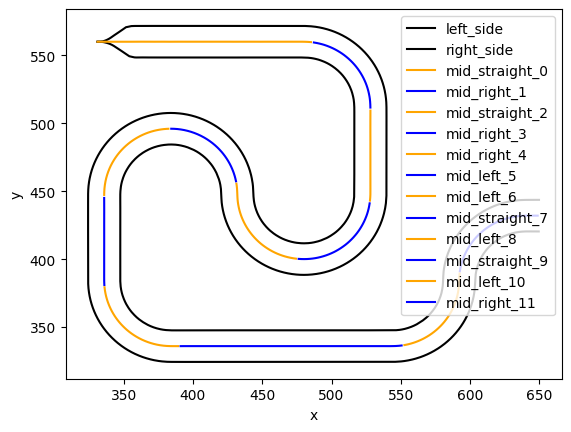

In [18]:
## Plot the road with all the information from the json file

left_side_road_coordinates = pd.read_csv('RL_map_training/road_left.csv')
right_side_road_coordinates = pd.read_csv('RL_map_training/road_right.csv')

with open('RL_map_training/dict.json', "r") as json_file:
    file_data  = json.load(json_file)

# file_data["road_sections"][0]["list_middle_points"]

# convert a list of list of 2 coordinates x and y to 2 lists, one with x and one with y
def convert_list_to_2_lists(list_of_list):
    x_values = []
    y_values = []
    for coordinates in list_of_list:
        x_values.append(coordinates[0])
        y_values.append(coordinates[1])
    return x_values, y_values


fig, ax = plt.subplots()

ax.plot(left_side_road_coordinates.x_values, left_side_road_coordinates.y_values, color='black', label='left_side')
ax.plot(right_side_road_coordinates.x_values, right_side_road_coordinates.y_values, color='black', label='right_side')

for idx, road_section in enumerate(file_data["road_sections"]):

    # convert a list of list of 2 coordinates x and y to 2 lists, one with x and one with y
    x_values, y_values = convert_list_to_2_lists(road_section["list_middle_points"])

    # Change color between sections
    if idx % 2 == 0:
        color='orange'
    else:
        color='blue'

    # Create the label of the section
    label = 'mid_'
    if road_section["direction_turn"] == 1:
        label += 'right_'
    elif road_section["direction_turn"] == -1:
        label += 'left_'
    else:
        label += 'straight_'
    label += str(idx)

    # Plot the middle points of the road
    ax.plot(x_values, y_values, color=color, label=label)

ax.set(xlabel='x', ylabel='y')
ax.legend()
plt.show()